In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score



The eigenfaces : chaining PCA and MLR, RFs
=============================================




Let's visualize these faces to see what we're working with



In [4]:
train_data = pd.read_csv('data/training.csv') 
test_data = pd.read_csv('data/test.csv') 
sample_data = pd.read_csv('data/SampleSubmission.csv') 
Id_data = pd.read_csv('data/IdLookupTable.csv') 

def flatten_images(images):
    return images.reshape(2140, 9216 )

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

#train_data = train_data.head(200)
train_data = train_data.dropna()

train_images = load_images(train_data)
print("Shape of train_images: {}".format(np.shape(train_images)))

train_keypoints = load_keypoints(train_data)
print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))

test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

Shape of train_images: (2140, 96, 96, 1)
Shape of train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)


In [5]:
train_images = train_images.reshape(2140, 96, 96)
train_images.shape

(2140, 96, 96)

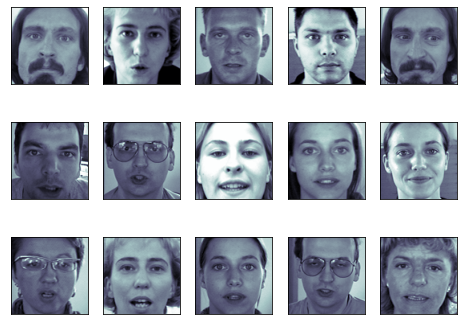

In [6]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(train_images.reshape(2140, 96, 96)[i], cmap=plt.cm.bone)

Preprocessing: Principal Component Analysis
-------------------------------------------

9216 dimensions are a lot for a Ridge regression. We can use PCA to reduce 
these 9216 features to a manageable size, while maintaining most of the 
information in the dataset.



In [7]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(train_images.reshape(2140, 9216))

PCA(n_components=150, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



In [8]:
train_images[0].shape#.reshape(1, 9216)

(96, 96)

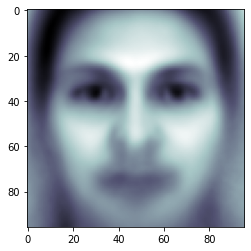

In [9]:
plt.imshow(pca.mean_.reshape(train_images.reshape(2140, 96, 96)[0].shape),      cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



It is also interesting to visualize these principal components:



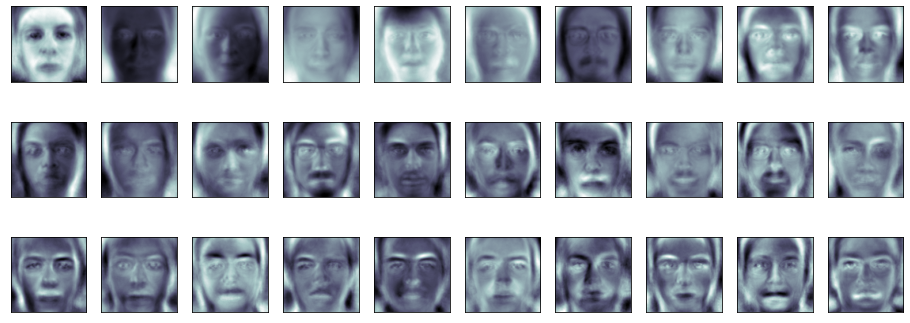

In [10]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(train_images.reshape(2140, 96, 96)[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.


These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: Ridge regression and Randon Forests
-------------------------------------------------------

Now we'll perform Ridge regression and Randon Forests on this reduced
dataset:

Pipelining
----------

Plugging the output of one estimator directly
into the input of a second estimator is a commonly used pattern; for
this reason scikit-learn provides a ``Pipeline`` object which automates
this process. The above problem can be re-expressed as a pipeline as
follows:

We can quantify this effectiveness using one of several measures
from `$r^2$`. 

In [24]:
def write_sub(regressor, y_pred ):
    lookid_list = list(Id_data['FeatureName'])
    imageID = list(Id_data['ImageId']-1)
    pre_list = list(y_pred)

    rowid = Id_data['RowId']
    rowid=list(rowid)

    feature = []
    for f in list(Id_data['FeatureName']):
        feature.append(lookid_list.index(f))

    preded = []
    for x,y in zip(imageID,feature):
        preded.append(pre_list[x][y])

    rowid = pd.Series(rowid,name = 'RowId')

    loc = pd.Series(preded,name = 'Location')

    submission = pd.concat([rowid,loc],axis = 1)

    
    
    fn = 'face_key_detection_submission_{}_{}.csv'.format(regressor, n)

    submission.to_csv(fn,index = False)

In [27]:
def get_res(y,y_pred):
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), accuracy_score(y_true, y_pred)

In [25]:
%%time
from sklearn.svm import SVR
def build_model(n, regressor='ridge'):

    if regressor == 'ridge':
        clf = Pipeline([
                        ('scalar', StandardScaler()),
                        ('pca', decomposition.PCA(n_components=n, whiten=True)),
                        ('ridge', MultiOutputRegressor(Ridge(random_state=123), n_jobs=4) )
                      ])

            
    clf.fit(train_images.reshape(2140, 9216), train_keypoints)
    model_score = clf.score(train_images.reshape(2140, 9216), train_keypoints, sample_weight=None)
    y_pred = clf.predict(test_images.reshape(1783 , 9216))
    write_sub(regressor, y_pred)
#     y_pred = X_test_pca
    return (model_score , y_pred)

for n in [500]:
    model_score, y_pred = build_model(n)
    print("Score = %0.2f" % model_score)


Score = 0.76
CPU times: user 30.8 s, sys: 26.1 s, total: 56.9 s
Wall time: 7 s


In [26]:
get_res(y_pred)

array([[64.45822186, 37.92122139, 28.71185552, ..., 69.68436572,
        47.16579147, 82.48012917],
       [67.53128504, 35.9475362 , 27.87860531, ..., 72.13401513,
        49.16644534, 86.93239615],
       [65.51816017, 35.64724153, 30.12090746, ..., 72.64024328,
        49.97628439, 84.64686079],
       ...,
       [67.59204947, 37.90310706, 29.9509684 , ..., 75.04302219,
        44.89981945, 81.3591095 ],
       [64.83062318, 35.93309106, 31.26579589, ..., 69.25800494,
        46.0818956 , 72.14020041],
       [67.01718029, 37.2141247 , 30.99566526, ..., 72.73685671,
        46.96414457, 82.51223231]])